# Fetching and playing with a pre-trained VGG Net (16) in Keras

Let's start by importing some packages we need. To simplify things somewhat, we're no longer going to use TensorFlow proper from this point on, we're going to move to a higher-level library called Keras.

In [25]:
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

## Getting a feel for the model and data it is trained on

In this notebook, we're going to fetch a network that is pre-trained on the [ImageNet](http://www.image-net.org) data set. In particular, we're going to fetch the [VGG Net](https://arxiv.org/abs/1409.1556) model with 16 layers (that we're going to refer to as `VGG16`).

ImageNet project is a large visual database designed for use in visual object recognition software research. As of 2016, over ten million URLs of images have been hand-annotated by ImageNet to indicate what objects are pictured. ImageNet crowdsources its annotation process.

![ImageNet Data Sample](images/imagenet-sample.jpg "ImageNet Data Sample")

Since 2010, the annual ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is a competition where research teams submit programs that classify and detect objects and scenes. (This is like the Olympics of computer vision challenges.)

VGG Net was introduced as one of the contenders in 2014's ImageNet Challenge. VGG Net secured the first and the second places in the localisation and classification tracks respectively. It was later described in great detail in [a paper](https://arxiv.org/abs/1409.1556) that came out the following year. The paper describes how a family of models essentially composed of simple 3x3 convolutional filters with increasing depth (11–19 layers, ReLU not shown for brevity) managed to perform so well at a range of computer vision tasks.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

We're going to first reproduce this 16 layer network marked in green for classification, and soon see how it can be repurposed for the style transfer problem.

## Fetching a pretrained model in Keras

This is trivial to do in Keras, and can be done in a single line. [There is a selection](https://github.com/fchollet/keras/tree/master/keras/applications) of such models one can import.

In [27]:
model = VGG16(weights='imagenet', include_top=True)
model.count_params()

138357544

Let's take a look at the model, convince ourselves it looks the same as the paper

In [26]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu_105:0' shape=(?, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_106:0' shape=(?, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool_35:0' shape=(?, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_107:0' shape=(?, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_108:0' shape=(?, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_36:0' shape=(?, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_109:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_110:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_111:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_37:0' shape=(?, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_112:0' shape=(?, 28, 28, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_113:0' shape=(?, 28, 28, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'R

We can also get a sense for how many parameters they are in this model.

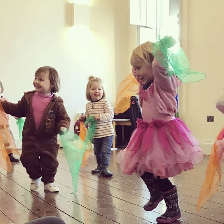

In [33]:
image_path = 'images/Sadie-dancing.png'
image = Image.open(image_path)
image = image.resize((224, 224))
image

In [35]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

('Predicted:', [(u'n03325584', u'feather_boa', 0.219768), (u'n04584207', u'wig', 0.15795456), (u'n09229709', u'bubble', 0.051168248)])


## Extension 1: The pre-trained model can be fine-tuned for your own classes

This is classic *transfer learning*. We will not go into this today, but a good worked out example can be found in [the Keras documentation](https://keras.io/applications/).

## Extension 2: Extracting features from a specific layer

We can *extract features* from a specific layer (using the names above).

In [24]:
from keras.models import Model
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('block4_pool').output)

block4_pool_features = model.predict(x)
print(block4_pool_features)
print(block4_pool_features.shape)

[[[[   0.            0.            0.         ...,    0.           82.01461029
       0.        ]
   [   0.            0.            0.         ...,    0.           85.68616486
       0.        ]
   [   0.            0.            0.         ...,    0.            0.
       0.        ]
   ..., 
   [   0.            0.            0.         ...,    0.          241.86521912
       0.        ]
   [   0.            0.            0.         ...,    0.          324.13943481
       0.        ]
   [   0.            0.            0.         ...,    0.          352.39898682
       0.        ]]

  [[   0.            0.            0.         ...,    0.          223.67085266
       0.        ]
   [   0.            0.            0.         ...,    0.          235.8238678
       0.        ]
   [   0.            0.            0.         ...,    0.           58.34262848
       0.        ]
   ..., 
   [   0.          177.63851929  143.94613647 ...,    0.          210.84683228
      33.22182846]
   [   0.

## Extension: Can be fine-tuned for your own classes (classic "transfer learning", not shown today)

````
Fine-tune InceptionV3 on a new set of classes

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(...)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)
```